# Random Forests - Redux

From Fastai ML1 [Lesson 1 Intro to Random Forests](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb)


This notebook turned into a redux of my [first RF Code Along](https://github.com/WNoxchi/Kaukasos/blob/master/FAML1/Lesson1-RandomForests.ipynb) with notes.

---

## 1 Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "../../data/competitions/bluebook-for-bulldozers/"

In [4]:
!ls {PATH}

Data%20Dictionary.xlsx		  Train.7z	     Valid.7z
Machine_Appendix.csv		  TrainAndValid.7z   Valid.csv
median_benchmark.csv		  TrainAndValid.csv  ValidSolution.csv
random_forest_benchmark_test.csv  TrainAndValid.zip  Valid.zip
Test.csv			  Train.csv
tmp				  Train.zip


## 2. Data

`low_memory=False` tells Pandas to read more of the file to decide what the types are.

`parse_dates=[...]` is used for any columns that contain dates.

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=['saledate'])

Entering a DataFrame to display it will truncate it if it's too long.
This function sets the truncation threshold to 1000 rows & cols.

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

`df_raw.tail()` will show the last few rows of the DataFrame. By default it shows the 
cols at top and rows on side. There're a lot of cols, so using `.transpose()` 
displays the table on its side.

In [7]:
# display_all(df_raw.tail().transpose())

In [8]:
# display_all(df_raw.describe(include='all').transpose())

In [9]:
# df_raw.head()

[RMSLE](https://www.kaggle.com/c/bluebook-for-bulldozers#evaluation) is used in the Kaggle competition. So by taking the log of all sale prices, we can just use RMSE later to calculate our loss. RMSLE: $Σ\big(($log(prediction) - log(actual)$)^2\big)$ : this means ratios not absolutes.

Here we also replace a column w/ a new column:

In [10]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### 2.2.2 Initial Processing

A Random Forest is smth of a universal machine learning technique. Could be a category or a continous variable - and can predict w/ cols of almost any kind (pixel data, zip codes, etc). RFs genrly don't overfit (prevention: easy). RFs don't genrly req validation sets, & can tell you how well they generalize - even w/ only 1 dataset. RFs have few if any statistical assumptions of your data, & req v.few pieces of feature engineering.

`model.fit(`__`Independant Variables`__`, `__`Dependent Variables`__`)`

Indep: used to predict; Dep: predicted. `pandas.DataFrame.drop(..)` returns a new DataFrame w/ a list of rows/cols removed. So we use everything but the SalePrice to predict the SalePrice.

In [11]:
model = RandomForestRegressor(n_jobs=-1) # n_jobs: number of cores to use. -1 ==> all
model.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

This dataset contains a mix of **continuous** and __categorical__ variables. Most ML models (incl. RFs) req numbers -- so we need to convert all our cols to numbers.


`sklearn.ensemble.RandomForestRegressor`: predict __continuous__ variables

`sklearn.ensemble.RandomForestClassifier`: predict __categorical__ variables

---

One issue is `saledate` was parsed as a date $ \longrightarrow $ as a number. But if we look at it, it isn't a number, it's a `datetime64` -- which is __not__ a number. So we need to do our first bit of feature engineering.

In [12]:
df_raw.saledate[:5]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

Inside `fastai.structured` is a function called `add_datepart`, which we'll use to fix this.

__Overview of `add_datepart`:__

1. We pass in a dataframe and a field (in this case `'saledate'`) to `add_datepart(df, fldname)`. We can't do `df.fieldname` because that'd return a field called 'fieldname'. So `df[fldname]` is how we grab a column when that column name is stored in the variable `fldname`. This gives us the field itself, the `pd.Series`.

2. `add_datepart` then goes through a list of date attribute strings ('Year', 'Month', 'Dayofyear', etc) and builds new columns by looking them up in `fld`'s datetime attributes (`fld.dt`).

3. It finally drops the original `fldname` column (`'saledate'` here) because it isn't numerical.

---

***NOTE***: `'saledate'` is a date type because we told Pandas to make it such via `parse_dates=["saledate"]`. That's why it has the relevant datetime attributes.

In [13]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

Now the datatype for `'saledate'` is numerical (`int64`). If we check the columns of the DataFrame we'll see the new ones added by `add_datepart`:

In [14]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


This isn't enough. One more bit of feature engineering is needed: there are strings in the dataset (`'Low'`, `'High'`) etc. FastAI has function to automatically create categorical variables for all strings - by creating a column (backend) mapping integers to strings.

FastAI also has a `apply_cats` function to preserve training-set category mappings for validation & test set use.

In [15]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


In [16]:
train_cats(df_raw)

Now we can access categorical variables as `.cat`attributes just as we could with `.dt` for datetime:

In [17]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

'High', 'Low', 'Medium' in `UsageBand` will be seen by the RF as cats `0`, `1`, `2`. It'll form a split first on either `0` vs `1, 2`, or `2` vs `0, 1`. That translates to 'High' vs 'Low' & 'Medium' or 'Medium' vs 'High' & 'Low'. That's a bit odd, and though the DT can get to a correct split regardless, by using a sensible ordering we can ensure it gets there in fewer splits - thus improving our model.

So we reorder 'High', 'Low', 'Medium' st. they're ordered wrt the category numbers, ie: so that any split starts by comparing 'High' and 'Low':

'High','Medium','Low' $\longrightarrow$ 0, 1, 2

`ordered=True` preserved supplied order, `inplace=True` changes the DataFrame in place instead of returning a new one.


In [18]:
df_raw.UsageBand.cat.set_categories(['High','Medium','Low'], ordered=True, inplace=True)

In [19]:
print(df_raw.UsageBand[100:110])
print(df_raw.UsageBand.cat.codes[100:110])

100    Medium
101    Medium
102    Medium
103      High
104       NaN
105       Low
106       Low
107      High
108    Medium
109    Medium
Name: UsageBand, dtype: category
Categories (3, object): [High < Medium < Low]
100    1
101    1
102    1
103    0
104   -1
105    2
106    2
107    0
108    1
109    1
dtype: int8


### 2.2.3 Preprocessing

We still have a number of Null values. Here we display the fraction of Null values in each category:

In [20]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

First we'll save our dataframe to disk in feather format since we have a good starting point.

In [21]:
os.makedirs(PATH + 'tmp', exist_ok=True)
df_raw.to_feather(PATH + 'tmp/raw')

Now we want to replace the string categories with their numeric codes, handle missing continous values, and pull out the dependant variable (`SalePrice`) into a separate variable. The `fastai.structured.proc_df` is what we'll use to do this.

---

**Overview of `proc_df`:**

`df:` DataFrame | `y_fld`: name of dependent variable

• Makes copy of DataFrame. • Grabs y values. • Drops DepVar from DataFrame. • Then fixes missing via `fastai.structured.fix_missing`.

>**Overview of `fix_missing`:**
>
>• Check that the column has missing values (`pd.isnull(col).sum() != 0`). • Create new column with same name as original + '_na' that's a boolean column w/ **1** any time a value is missing, **0** otherwise. • Then replace all Null values with the columns median.
>
>ie: All NaNs replaced by col's median. New col added keeping track of NaNs.

That is done for numeric variables (cols) -- Pandas automatically handles categorical variables by setting them to `-1` if missing.

• Then call `fastai.structured.numericalize`.

>**Overview of `numericalize`:**
>
>• If column is **Not** numeric and **is** a categorical type: replace column w/ it's category codes (integers) + 1.

---

In [22]:
df, y, nans = proc_df(df_raw, 'SalePrice')

'SalePrice' is now absent from the DataFrame's columns, and all columns with a non-zero value for null-fractions have corresponding '_na' columns.

In [23]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

If we check the DataFrame, we see that everything is now a number:

In [24]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


Now we have something we can pass into a Random-Forest Regressor.

In [25]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(df, y)
model.score(df, y)

0.9831855416872145

***NOTE***: Random Forests are *trivially* parallelizable, meaning computation time more/less linearly scales (negatively) with number of CPUs.

The score is the R$^2$ value. Range is < 1. 1 is perfect. If your R$^2$ score is < 0 your model is worse than predicting the mean. [FastAI ML1 L2 bit on R2](https://youtu.be/blyXCk4sgEg?t=718). **Gist of R$^2$:** *the ratio between how good your model is (RMSE) vs. how good is the naïve mean model (RMSE)*.

We'll create a simple validation set to test this. The dataset is sorted by date, so the most recent `n` rows will make up the validation set.

In [26]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 # same as Kaggle's test set size # 12000 rows for val set
n_trn = len(df) - n_valid                        # all else in trn set
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

## 3. Random Forests

### 3.1 Base Model

Now we'll run our model again, but with the separate training and validation sets:

In [27]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [28]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 1min 34s, sys: 260 ms, total: 1min 34s
Wall time: 29.3 s
[0.090431376571641, 0.247444226266789, 0.9829087782181651, 0.8906540698336106]


There was some overfitting going on -- but this 0.252 loss gets into the top 25% of the Kaggle public leaderboard.

---
[Fast.ai ML1 L2](https://youtu.be/blyXCk4sgEg?t=1114) p.much picks up from here.

Since the data/competition is predicted time-series data -- you want your validation set to reflect that by being a range of consecutive dates (specifically some tail slice of the dataset).

### 3.2 Speeding things up

One way to speed up iteration time for model development is to use the `subset` parameter in `proc_df`: which returns only a subset of the data to work on. This returns a randomly sampled subset of the data.

We need to make sure our train-subset doesn't overlap with our validation set. We also want to use our original val set, and **not** overwrite it, so of the 30k subset, we set the first 20k (this may overlap a bit..) to be training, and throw the rest away.

* Create `df_trn`, `y_trn` from a random 30k subset of `df_raw`. 
* Set `X_train`, `y_train` to be the first 20k rows of `df_trn`, `y_trn`.

In [29]:
df_trn, y_trn, nans = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn,  20000)

In [30]:
model = RandomForestRegressor(n_jobs=-1) ## initialize Model
%time model.fit(X_train, y_train)        ## train Model
print_score(model)                       ## run predictions - still using orig valset

CPU times: user 3.81 s, sys: 4 ms, total: 3.82 s
Wall time: 1.27 s
[0.11279606685210727, 0.37086225223751285, 0.9718434771785658, 0.7543746215442799]


Loss Train, | Loss Valid, | R2 Train, | R2 Loss

### 3.3 Single Tree

Scikit-Learn calls trees estimators. `max_depth` is depth of splits. `bootstrap` controls random:on/off for Random Forest.

In [31]:
# A small Deterministic Decision Tree
model = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

[0.525145713138213, 0.5808629267861516, 0.38968961849576, 0.39744694659014135]


`fastai.structured.draw_tree` lets us visualize Decision Trees. `model.estimators_[0]` returns the 1st estimator from an array.

In [32]:
# model.estimators_

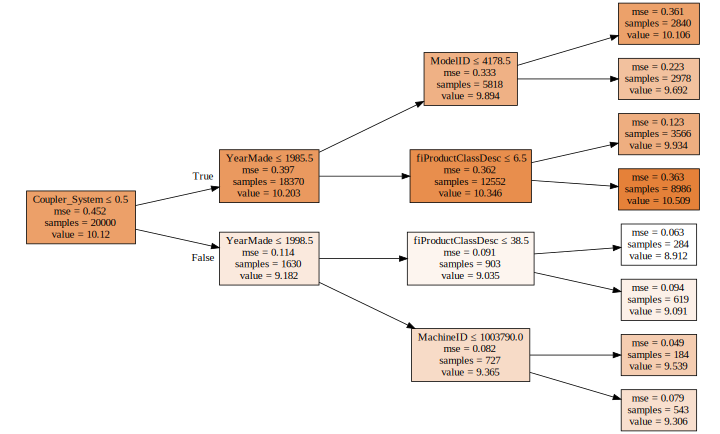

In [33]:
draw_tree(model.estimators_[0], df_trn, precision=3)

We have 20k samples at the start of the this tree - because that's what we made the training set as when we split our data.

Looking at first node: in our whole dataset (X_train) there're 20k rows, the average sale price is ~10.1, and if we built a model where we used that average all the time: then our MSE would be 0.452. Iow that's the denominator of an R2. This 1st node is the most basic model: a tree with zero splits - just predict the average.

The best single split the RF is able to make is based on whether the Coupler_System is ≤ 0.5 (True / False). If it does that, the MSE of Coupler_System > 0.5 (False) goes to 0.114: a large improvement. In the other group: Coupler_System ≤ 0.5 (True) improves slightly to 0.397. The False group is a small fraction: ~1,700/20,000.

---

**How to find the best possible split with a Single Decision Tree?**:

* **For each** categorical variable:
    * **For each** value of that variable:
        * **Find** the split with the Minimum weighted-average MSE
* **Return** the categorry:value split w/ Minimum weighted-average MSE

Equivalent to this is to take the MSE of a hypothetical model where all values of a binary split are set to their decisions average.

---

Now we can improve this Decision Tree by setting `depth=None` to continue until each leaf node has only one decision possible for it. If we do that (surprise) we get a model that perfectly overfits our data. Our validation loss/error is not 1, but is better than our shallow tree.

In [34]:
model = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

[5.756054031998178e-17, 0.47752222900820246, 1.0, 0.5927743171457405]


### 3.4 Bagging

#### 3.4.1 Intro to Bagging

We can improve these D.Trees by making forests of them. We create forests with a statistical technique called 'bagging'. Any kind of model can be bagged. A Random Forest is a way of bagging trees.

What if we created `N` different models, each of which was only somewhat predictive, but the models weren't at all corelated with eachother. That means the `N` models would had to have found different insights into the relationships in the data. If you took the average of those `N` models, you're effectively bringing in the insights from each of them. This is Ensembling.

What if we made a bunch of these big, deep, strongly-overfit trees, but each one only gets a random 1/10th of the data. So each tree will be perfect on that subset but bad at the rest. So each of the trees will be better than nothing, and all overfit in different ways on different things because they use different random samples. 

So they all have errors, but the errors are random. The average of a bunch of random errors is **Zero**.

So if we take the average of all these trees (ea. of which trained on a dfnt rand subset) the errors will average out to zero and what's left is the true relationship. *That* is a **Random Forest**. [Lecture 2](https://youtu.be/blyXCk4sgEg?t=2971)

---

1. Grab random subset of data.
2. Build a Decision Tree on it.
3. Put that D.Tree aside and repeat `N` times
4. For each D.Tree make predictions by running test data through tree to get to leaf node
5. Take average in that leaf node $\forall$ the trees
6. Average them all together.

To do that we call `RandomForestRegressor`. An estimator (specfd by `n_estimators`) is a D.Tree.

---

The key insight is to construct multitple models that are better than nothing and where the errors are as much as possible uncorrelated with eachother. If the errors are correlated this breaks down.

For subsets, Scikit-Learn picks out `n` rows *with* replacement. This is called bootstrapping. This on average represents 62.3% of the rows, with a bunch represented multiple times. ***(I think this means 62.3% rows used on any given tree).***

[Lecture 2:](https://youtu.be/blyXCk4sgEg?t=3146) So instead of picking out a 1/10 of the rows, of an `n` row dataset, we pick out `n` rows with replacement, which on average represnts 62.3% of the rows, many of them multiple times.

*Aside:* The Whole point of modeling Machine Learning is to find a model that tells you which variables are important and how they interact together to drive your independent variable. The difference between using 'Tree Space / Random-Forest Space' and 'Euclidean Space' to find nearest neighbors is the difference between a model that makes good predictions and one that makes meaningless predictions.

---

In **Bagging** you want each of your individual estimators / trees to be as predictive as possible and for their predictions to be as uncorrelated as possible. The inventor of RFs in the 1990s spoke about this: trying to come up with predictive but poorly-correlated trees.

Recent research has shown correlation is more important than individual predictiveness: so recent methods focus on creating trees which are less accurate on their own, and aim to minimize correlation between trees. Scikit-Learn has an ExtraTrees[Regressor/Classifier] with the exact same API as RandomForest[R/C] (and can be dropped in to replace it) which stands for "Extremely-Randomized Trees Model" Instead of trying every split of every variable, it randomly tries a few splits of a few variables. It's much faster to train, has much more randomness, and in that time you can build more trees and get better generalization.

In [35]:
model = RandomForestRegressor(n_jobs=-1) # default is 10 estimators
model.fit(X_train, y_train)
print_score(model)

[0.11125989229028178, 0.3708225122739393, 0.9726051845817276, 0.7544272589887925]


We'll grab predictions for each individual tree and look at one example. After you've built a RF, each tree is stored in the attribute: `.estimators_`

In [36]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0] # print first tree's predictions

(array([9.51044, 9.15905, 9.82553, 9.21034, 9.3501 , 9.30565, 9.21034, 9.79813, 9.3501 , 9.07681]),
 9.379648999374709,
 9.104979856318357)

In [37]:
preds.shape # 12,000 predictions for each of 10 trees

(10, 12000)

Notice that most of the predictions were a bit off, but the mean of all of them is pretty good. 9.459 avg, 9.105 actual.

Here's a plot going through each of the 10 trees, taking the mean of all the predictions up to the i$^{th}$ tree (1st tree, 1st 2 trees, 1st 3 .. etc), and plot the R$^2$. Notice the final value on the plot matches the R$^2$ value of the model up above.

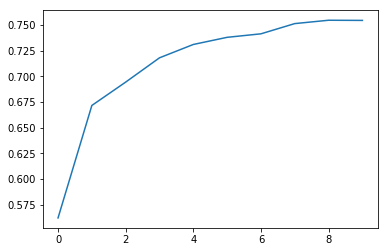

In [38]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Also note the plot's flattening out. (tested in original notebook and course nb): adding more trees won't improve the model much beyond this point.

The `n_estimators` hyperparameter is chosen based on:
1. amount of time you have for fitting
2. point of diminshing returns

More trees slows model fit/train time, but fewer trees can still offer valuable insight. J.Howard will often work through a day with a 20-tree RF, and at the end expand that to a 1000-tree model.

#### 3.4.2 Out-of-Bag (OoB) Score

Sometimes your dataset will be too small to create a validation set and a good model at the same time. There's a trick unique to Random Forests for this:

Recognize that some for each tree, some dataset rows did not get used. So pass those rows through those trees as their validation sets.

So you end up with a different validation set for each tree. Now to calculate our prediction we average all the trees where that row was not used for training. As long as you have enough trees every row will appear in the OoB sample for one of them at least.

So you create an OoB prediction by averaging all the trees you didn't use to train each individual row, then calculate your RMSE, R2, etc on that.

You can do this automatically by specifying the `oob_score=True` parameter in Scikit-Learn's `RandomForestRegressor`, creating a `.oob_score_` attribute in the resulting model.

In [39]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

[0.0969800601698621, 0.3598780368852427, 0.9791859781228975, 0.7687090395771896, 0.8526215860050095]


The OoB Score will usually slightly underestimate the generalizability of the model -- the more trees you have, the less the underestimation of the model - but it works well enough anyway.

### 3.5 Reducing Over-Fitting

#### 3.5.1 Subsampling

One of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so we can demonstrate the impact of this technique.

___

***NOTE***: before we took a subset of 30k rows of the data and built every model on that. Meaning every tree in the RF is a different subset of that subset of 30k. Why not pick a totally different subset of 30k each time. ie: leave the entire dataset of 300k records as is, and if we want to make things faster: pick a different subset of 30k each time. So rather than bootstrapping the entire set of rows: let's just randomly sample a subset of data.

---

So we'll do this by calling `proc_df` without our subset parameter:

In [41]:
df_trn, y_trn, nans = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* of the data, but for each individual tree, it'll be just as fast as if we had cut down our dataset as before.

Calling `fastai.structurered.set_rf_samples(n)` will change Scikit-learn's random forests to give each tree a random sample of `n` random rows.

When we do this, now when we run a RF, it's not going to bootstrap an entire set of 391k rows (len(X_train)), it'll just grab a subset of 20k rows. So when we run `set_rf_samples(20000)` it'll still run just as quickly as if we'd've originally done a random sample of 20k, but now every tree can have access to the entire dataset.

So if we use enough D.Trees, the RF will eventually see everything.

In [43]:
set_rf_samples(20000)

In [44]:
model = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 9.34 s, sys: 468 ms, total: 9.81 s
Wall time: 5.08 s
[0.23997123416668353, 0.281977920276786, 0.8796480320055804, 0.858003323331318, 0.866939014437051]


Now with 10 estimators (default) we get an R2 of 0.858.

In [45]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 35.7 s, sys: 1.41 s, total: 37.1 s
Wall time: 15.8 s
[0.22756958930029839, 0.26205133591808527, 0.8917661075126084, 0.8773632225160998, 0.8801800231758763]


Increasing to 40 esimates increases our R2 score from 0.858 to 0.877.

---

`set_rf_samples` will be very useful for working with massive structured datasets.

Unfortunately as of 31/10/2017 (and now 25/3/2018) it will not change how OoB is calculated (`set_rf_samples` is a hack that replaces scikit-learn's internal function call with a lambda function with the desired behavior). OoB should be turned off for now when `set_rf_samples` is used.

***NOTE*** to **reset** the RF sampling: call `fastai.structured.reset_rf_samples()`

---

When doing EDA (Exploratory Data Analysis) ie: when working and probing at a problem / doing interactive machine learning, [J.Howard](https://youtu.be/blyXCk4sgEg?t=4791) will use `set_rf_samples` (subsets) and reasonable small forests, because:
> all the insights that I'm going to get are exactly the same as the big ones, but I can run them in 3 or 4 seconds instead of hours.

> this is one of the biggest tips I can give you, and very very few people in industry or academia actually do this. Most people run all of their models on all of the data all of the time using their best possible parameters, which is just pointless.

> if you're trying to find out which features are important and how they're related to each other and so forth: having that 4th decimal place of accuracy isn't going to change any of your insights at all.

> do most of your models on a large enough sample size that your accuracy is reasonable (w/n a reasonable distance of the best accuracy you can get) and is taking a small number of seconds to train - so you can interactively do your analysis.

#### 3.5.2 Tree-building Parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [48]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [49]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 6min 18s, sys: 988 ms, total: 6min 19s
Wall time: 1min 39s
[0.07842487866176874, 0.23918781214271065, 0.9871458744654089, 0.8978293710994207, 0.9083933718091257]


Each of the estimators will train all the way down until the leaf nodes have 1 sample in them. **NOTE** that our OoB score is better than our validation R2 score (.89278) because our validation set is **not** a random sample: it's a different time period, and it's much harder to predict an entirely different time period than it is to predict random dates.

---

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leafe node. This has 2 benefits:
* There are fewer decision rules for each leaf node; simpler models should generalize better
* The predictions are made by averaging more rows in the leaf node, resulting in less volatility

example: `min_samples_leaf=3`: stop training the tree further when your leaf node has 3 or less samples in it.

In practice this means there'll be 1 or 2 fewer levels of decisions being made, which means about half or a quarter the number of actual decision criteria we have to do -- so it'll train quicker. It means also when we look at an individual tree, rather than just taking 1 point, we're taking the average of at least 3 points -- so we expect each tree to generalize a bit better; but ea. tree is also likely to be less powerful on its own.

In [50]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 5min 22s, sys: 732 ms, total: 5min 23s
Wall time: 1min 25s
[0.11503700539769621, 0.23330848662578932, 0.9723426884651744, 0.9027904243770585, 0.9085656903600993]


Values of **1, 3, 5, 10, 25** tend to work well for `min_samples_leaf`.

If working with a massive dataset without subsampling, you may need values of hundreds or thousands.

---

Here we see increasing `min_samples_leaf` from 1 to 3 has increased our Validation R$^2$ from 0.898 to 0.903. So it's a slight improvement and trains a bit faster.

---

We can also increase the amount of variation amongst the trees by not only using a sample of rows for each tree, but also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

In [52]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 2min 52s, sys: 148 ms, total: 2min 52s
Wall time: 47.4 s
[0.11924543662523952, 0.22893288409507787, 0.9702820832112764, 0.9064024818437162, 0.9115301725386481]


Our model now has a validation R2 of 0.906. Our RMSE of log(price) has dropped from 0.233 to 0.229 as well. How good is that? Well on the [Kaggle public leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard) a loss of 0.2289 puts us in the top 20 of the competition. That's with a *"totally brainless random forest with some totally brainless minor hyperparameter tuning."*

> This why the Random Forest is such an important - not just first step but often only step in Machine Learning. Because it's hard to screw it up (even when we didn't tune the hyperparameters we still got a good result), and a small amt of hypar tuning got a much better result. 

>So any kind of model - specifically Linear-type models which have a whole bunch of statistical assumptions and require a bunch of prereqs to get right before they start to work at all - can really throw you off track because they can give you totally wrong answers about how accurate the predictions can be.

>The Random Forest generally-speaking tends to work on most datasets most of the time with most sets of hypars.

-- [J.Howard Fast.ai ML1 Lecture 2](https://youtu.be/blyXCk4sgEg?t=5370)

Random Forests work because the trees are p.much infinitely flexible. Even with a categorical variable - if there're particular categories which have different levels of price: it can gradually zoom in on those groups by using multiple splits.

You can help it by telling it the order of your CatVar, but even if you don't: it's okay, it'll just take a few more decisions to get there.

In a Linear model, or almost *any* other kind of model, especially non-tree models, encoding  CatVars the way RFs do won't work - because there's no linear relationship between arbitrary identifiers.

---

>What does `max_features` do? The idea is that the less correlated your trees are w.eachother, the better. Imagine you had 1 column that was so much better than all the others at being predictive, that every single tree you built - regardless of which subset of rows - always started with that column. So the trees will all be pretty similar.

>But you can imagine there might be some interaction of variables where that interaction is more important than that individual column. So if every tree always fits on the same thing the 1st time, you're not going to get much variation in those trees.

>So what we do is in addition to just taking a subset of rows: we then at every single split point take a different subset of columns.

>This is slightly different than row sampling. In row-sampling each new tree is based on a random set of rows. For column sampling every individual binary split we choose from a different subset of columns.

>In other words: rather than looking at every possible level of every possible column: we look at every possible level of a random subset of columns. And each binary split / decision point we use a different random subset.

>How many? you get to pick. `max_features=0.5` means randomly choose half of them. The default is to use all of them. There are also some special parameters you can pass in (sqrt, log, etc).

>In practice I've found good values to be 1, 0.5, log(2), or sqrt -- that'll give you a nice bit of variation.

-- [J.Howard Fast.ai ML1 Lecture 2](https://youtu.be/blyXCk4sgEg?t=5049)

---

As an example: here's what the Random Forest sees when it's making it's split decisions:

In [55]:
df_raw.fiProductClassDesc.cat.codes

0         58
1         61
2         38
3          7
4         39
5          1
6         13
7          1
8         16
9         67
10         1
11        50
12        11
13         1
14         1
15         1
16        16
17        19
18        12
19         1
20        14
21        34
22        12
23        63
24         1
25        38
26        12
27        23
28        34
29        21
          ..
401095    16
401096    16
401097    16
401098    16
401099    16
401100    16
401101    16
401102    16
401103    16
401104    16
401105    16
401106    16
401107    16
401108    16
401109    16
401110    16
401111    16
401112    16
401113    16
401114    16
401115    16
401116    16
401117    16
401118    16
401119    12
401120    16
401121    16
401122    16
401123    12
401124    12
Length: 401125, dtype: int8

In [54]:
df_raw.fiProductClassDesc.cat.categories

Index(['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
       'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
       'Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth',
       'Backhoe Loader - 16.0 + Ft Standard Digging Depth',
       'Backhoe Loader - Unidentified',
       'Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons',
       'Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons',
       'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
       'Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons',
       'Hydraulic Excavator, Track - 150.0 to 300.0 Metric Tons',
       'Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons',
       'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
       'Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons',
       'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
       'Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons',
       'Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons',
 